# HW 3
In this homework assignment, **you are going to describe your final project research topic using open data and visualizations**. 

#### You must use in this notebook: 
- Census data and census geometries through the Census API.
- At least two maps that describe some aspect of the topic
- At least one chart in seaborn or matplotlib that describe some aspect of the topic.
- Optional: 
    - Socrata API
    - Google maps API
    - Other datasets that you might want to bring in. 

#### Grading
The grading breakdown for this assignment will be based on the following: 
- One paragraph description of the research topic (5 pts)
- One paragraph description of the datasets and methods you use to describe this topic (5 pts)
- Descriptive statistics and data summaries that are relevant for this topic, with the requirement that you use the Census through the API and, optionally, other data sources. (5 pts)
- Data cleaning and justifications, along with any additional analyses (buffers, spatial joins, group-by-summarize, etc) (15 pts)
- Two maps that show different aspects of your research topic (5 pts each)
- One chart that shows an aspect of your research topic (5 pts)

#### Due date
- Feb 28 (Wednesday) at 11:59pm. 

#### Deliverables
- This notebook and any related data files in zip file

# Example project idea
Here is something I grabbed from the [Urban Institute](https://www.urban.org/projects/exploring-spatial-gaps-access-low-wage-jobs-race-and-ethnicity) that would fit this assignment: 

>**Spatial Gaps in Access to Low-Wage Jobs by Race and Ethnicity**
>
>In many cities across the US, access to employment opportunities is not evenly distributed. A history of racist housing policies at the local, state, and federal levels has led to segregated neighborhoods and an unequal transportation landscape that keep many people of color far from opportunity. This spatial mismatch between where jobs are located and where job seekers live can cause high unemployment rates and lead to longer spells of joblessness.
>
>For this project, we examine how access to job opportunities for low-wage workers varies based on their race/ethnicity and where they live. For select metropolitan regions, we compare gaps in access to low-wage jobs between workers who are white and workers who are people of color. To do so, we create a measure that shows how many low-wage jobs are available to low-wage workers and people who are unemployed within a 30-minute commute...

**This description does two things succinctly**: 
1) It briefly describes the problem: unequal spatial access to employment opportunities across race/ethnicities. 
2) It specifies how this problem will be measured: through the notion of "spatial mismatch", which is the discrepancy between where jobs are adn where job seekers are. 

**This project uses three datasets on a selection of metropolitan areas**: 
- ACS 5YR on race and ethnicity at the Census tract level
- [Longitudinal Employer Household Dynamics (LEHD)](https://lehd.ces.census.gov/data/) on the home to work flows at the Census tract level 
- 30 minute commute buffers for transit stations. 

**How you might use this research topic for the assignment (please pick another research topic)**: 
- Pick one smaller city that you hypothesize might have uneven spatial access issues (to keep it manageable), for instance San Francisco. 
- Using census data, map the % non-White in each tract. 
- Using the LEHD data, find the 10 tracts with the highest number of low-wage jobs (call it "job tracts"). 
- Calculate the distance between each tract in the city and the closest "job tracts" using geopandas
- OR find a 30 minute driving buffer for those "job tracts" using geopandas and see which tracts fall within them. 
- OR find each tract's driving distance and duration to the closest "job tract" using google maps API, which you can also adjust for different kinds of transit (for ex: by car, public transit, walking)
- Map the driving distances for each tract in another choropleth map, making sure to include the "job tracts". 
- Create a scatter plot with distance/time to "job tract" on the x-axis and % non-White on the y-axis. 


#### If you need some inspiration for research topics: 
Here are some more from the [Urban Institute](https://www.urban.org/topics): 

**Economic mobility and inequality**
- [Creating better metrics for economic mobility](https://www.urban.org/policy-centers/research-action-lab/projects/boosting-upward-mobility-poverty/publications)

**Education**
- [Neighborhood segregation and school segregation](https://www.urban.org/data-tools/segregated-neighborhoods-segregated-schools)

**Ageing**
- [How might older adults or those with disabilities in public housing receive the services they need?](https://www.urban.org/research/publication/meeting-challenge-serving-older-adults-and-people-disabilities-public-housing)

**Housing**
- [Housing resilience in New Orleans in the post-Katrina era](https://www.urban.org/research/publication/housing-resilience-greater-new-orleans)

**Land Use**
- [The potential for office space conversions to revitalize public transit use](https://www.urban.org/urban-wire/office-space-conversions-could-help-transit-agencies-regain-riders-and-surmount-their)
- [How zoning changes near transit can help with housing affordability](https://apps.urban.org/features/affordable-housing-shortage-and-zoning/)

**Neighborhoods, cities, and metros**
- [Did private investment to address homelessness in San Francisco seem to have a meaningful impact?](https://www.urban.org/policy-centers/metropolitan-housing-and-communities-policy-center/projects/tipping-points-chronic-homelessness-initiative)
- [Are historic redlining maps strong predictors of present-day housing instability?](https://www.urban.org/features/ghosts-housing-discrimination-reach-beyond-redlining)



In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context(context='paper')

%matplotlib inline

from census import Census
from us import states

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
c = Census("172c2f047265e49507cff51bddf0f0d7f7350886") #my census key

In [39]:
#query data, category codes from: https://api.census.gov/data/2021/acs/acs5/variables.html
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'B06011_001E','B01001_001E', 'B01001A_001E', 'B01001B_001E'),
                                      state_fips = states.NY.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2021)

In [70]:
#create data frame, name columns, and create column for geoid
ny_df = pd.DataFrame(ny_census)
ny_df = ny_df.rename(columns={'B06011_001E':'median income', 
                      'B01001_001E':'population', 
                      'B01001A_001E':'population white', 
                      'B01001B_001E':'population black'})

ny_df["GEOID"] = ny_df["state"] + ny_df["county"] + ny_df["tract"]

#also create column for percentage non-white, and percentage black
#use np.where to guard against division by zero
ny_df['perc nonwhite'] = np.where(ny_df['population']==0, np.nan, 1 - ny_df['population white'] / ny_df['population'])
ny_df['perc black'] = np.where(ny_df['population']==0, np.nan, ny_df['population black'] / ny_df['population'])

In [71]:
#I'm only going to work with nyc data, so I filter the relevant counties by county FIP code
nyc_df = ny_df[ny_df['county'].isin(['005', '047', '061', '081', '085'])].reset_index()

In [72]:
#add shapefiles
ny_tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip')
nyc_census_geo = ny_tract[['NAMELSAD', 'GEOID', 'geometry']].merge(nyc_df, left_on = 'GEOID', right_on = 'GEOID')

In [73]:
# overview of census data
nyc_census_geo.describe()

# I also visualized the data, but this is slow, so I comment it out
# nyc_census_geo.explore()

,index,median income,population,population white,population black,perc nonwhite,perc black
count,2327.000000,2.327000e+03,2327.000000,2327.000000,2327.000000,2239.000000,2239.000000
mean,2366.779974,-2.832365e+07,3754.210142,1493.255264,877.765363,0.605573,0.244826
std,1313.218269,1.345883e+08,2089.412670,1496.333265,1145.861667,0.282787,0.283043
min,101.000000,-6.666667e+08,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1429.500000,2.609200e+04,2298.500000,375.000000,56.000000,0.358776,0.021060
50%,2011.000000,3.445000e+04,3520.000000,1074.000000,307.000000,0.656214,0.099688
75%,3671.500000,4.550950e+04,4919.000000,2118.000000,1437.000000,0.867782,0.423046
max,4301.000000,2.156250e+05,16629.000000,12129.000000,7006.000000,1.000000,1.000000


In [60]:
#I realized there is some tracts with income as -666666666
#these tracts cover mostly water, so I just replace them with nan values
nyc_census_geo['median income'] = nyc_census_geo['median income'].replace(-666666666, np.nan)

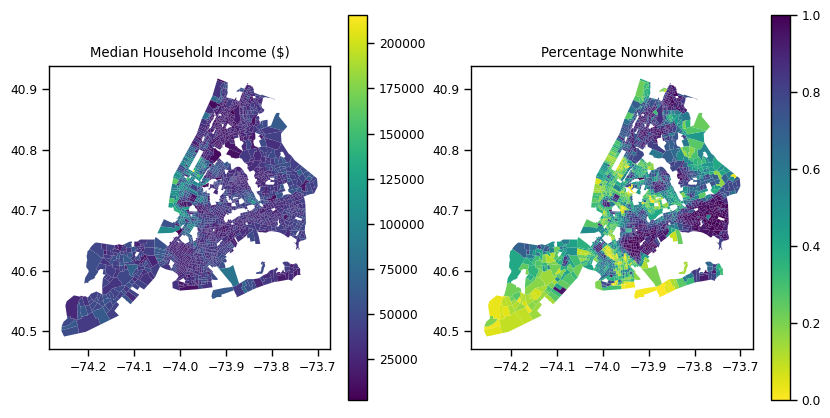

In [83]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 'median income' on the first subplot
nyc_census_geo.plot('median income', legend=True, ax=axes[0])

# Plot 'perc nonwhite' on the second subplot, reverse the color scale
nyc_census_geo.plot('perc nonwhite', legend=True, ax=axes[1], cmap='viridis_r')

axes[0].set_title('Median Household Income ($)')
axes[1].set_title('Percentage Nonwhite')

plt.show()

In [ ]:
ny_tract = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip')